In [1]:
import gc
from math import ceil
from time import time_ns

import matplotlib.pyplot as plt
import numpy as np
import numba as nb
from tqdm import tqdm

In [2]:
def iterative(d):
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        if d[idx] > 50:
            r[idx] = d[idx] * 2
        else:
            r[idx] = d[idx] * -2
    return r

In [3]:
@nb.njit
def iterative_jit(d):
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        if d[idx] > 50:
            r[idx] = d[idx] * 2
        else:
            r[idx] = d[idx] * -2
    return r

In [4]:
@nb.njit(parallel = True)
def iterative_jit_parallel(d):
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in nb.prange(d.shape[0]):
        if d[idx] > 50:
            r[idx] = d[idx] * 2
        else:
            r[idx] = d[idx] * -2
    return r

In [5]:
def masked_array(d):
    r = np.zeros(d.shape, dtype = d.dtype)
    mask = d > 50
    r[mask] = d[mask] * 2
    r[~mask] = d[~mask] * -2
    return r

In [6]:
@nb.njit()
def masked_array_jit(d):
    r = np.empty(d.shape, dtype = d.dtype)
    mask = d > 50
    r[mask] = d[mask] * 2
    r[~mask] = d[~mask] * -2
    return r

In [7]:
@nb.vectorize
def vectorized_array_jit(d):
    if d > 50:
        r = d * 2
    else:
        r = d * -2
    return r

In [8]:
@nb.njit('f8(f8)', inline = 'always')
def _inline_always_a(d):
    return d * 2

@nb.njit('f8(f8)', inline = 'always')
def _inline_always_b(d):
    return d * -2

@nb.vectorize('f8(f8)', nopython = True)
def vectorized_array_jit_inline_always(d):
    if d > 50:
        r = _inline_always_a(d)
    else:
        r = _inline_always_b(d)
    return r

In [9]:
@nb.njit('f8(f8)', inline = 'never')
def _inline_never_a(d):
    return d * 2

@nb.njit('f8(f8)', inline = 'never')
def _inline_never_b(d):
    return d * -2

@nb.vectorize('f8(f8)', nopython = True)
def vectorized_array_jit_inline_never(d):
    if d > 50:
        r = _inline_never_a(d)
    else:
        r = _inline_never_b(d)
    return r

In [10]:
@nb.vectorize('f8(f8)', target = 'parallel')
def vectorized_parallel_array_jit(d):
    if d > 50:
        r = d * 2
    else:
        r = d * -2
    return r

In [11]:
@nb.vectorize
def _parallel_array_jit_helper(d):
    if d > 50:
        r = d * 2
    else:
        r = d * -2
    return r

@nb.njit(parallel = True)
def parallel_array_jit(d):
    r = np.zeros(d.shape, dtype = d.dtype)
    chunks = nb.config.NUMBA_NUM_THREADS if nb.config.NUMBA_NUM_THREADS > r.shape[0] else r.shape[0]
    chunk_size = ceil(r.shape[0] / chunks)
    for chunk in nb.prange(chunks):
        r[chunk*chunk_size:(chunk+1)*chunk_size] = _parallel_array_jit_helper(d[chunk*chunk_size:(chunk+1)*chunk_size])
    return r

In [12]:
funcs = [
    iterative,
    iterative_jit,
    iterative_jit_parallel,
    masked_array,
    masked_array_jit,
    vectorized_array_jit,
    vectorized_parallel_array_jit,
    parallel_array_jit,
    vectorized_array_jit_inline_always,
    vectorized_array_jit_inline_never,
]

In [13]:
def test_all(size = 100):
    
    data = np.random.random(size) * 100
    res_base = funcs[0](data)
    
    for func in funcs[1:]:
        res = func(data)
        assert np.allclose(res_base, res)
        
test_all()

In [14]:
def benchmark(start = 4, stop = 26, reps = 5):  # 26
    sizes = (2 ** np.arange(start, stop + 0.5, 0.5)).astype('i8')
    results = {func.__name__: [] for func in funcs[1:]}
    gc.disable()
    for size in tqdm(sizes):
        data = np.random.random(size) * 100
        for func in funcs[1:]:  # exclude pure python
            runtimes = []
            for rep in range(reps):
                gc.collect()
                start = time_ns()
                _ = func(data)
                runtime = time_ns() - start
                runtimes.append(runtime)
            results[func.__name__].append(min(runtimes) * 1e-9)
    gc.enable()
    return sizes, results

s, r = benchmark()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [02:20<00:00,  3.12s/it]


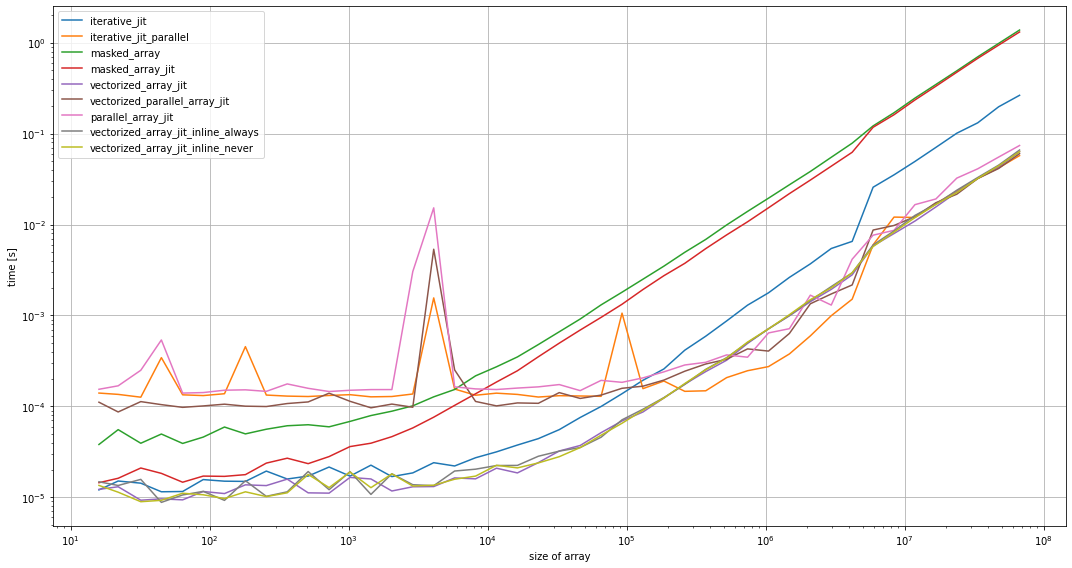

In [15]:
def plot(sizes, results):
    fig, ax = plt.subplots(figsize = (15, 8))
    for name, values in results.items():
        ax.loglog(sizes, values, label = name)
    ax.legend()
    ax.set_xlabel('size of array')
    ax.set_ylabel('time [s]')
    ax.grid()
    fig.tight_layout()

plot(s, r)